<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators2/blob/main/embeddings/AuthorDetect_AuthorEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install AuthorDetect from GitHub repository

In [ ]:
!pip install git+https://github.com/edponce/DoyleInvestigators2

# Set up NLTK

In [ ]:
import nltk

nltk.download('stopwords')
# Sentencizer
nltk.download('punkt')
# Tagger
nltk.download('averaged_perceptron_tagger')
# Universal POS tags
nltk.download('universal_tagset')
# Stemmers
nltk.download('wordnet')
nltk.download('rslp')

In [4]:
from authordetect import Author, Tokenizer
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# User Configuration

In [5]:
infile = '/content/gdrive/My Drive/2020/NLP/project2_data/Doyle.txt'
workers = 1
seed = 0

# Processing

In [6]:
# Load corpus
a = Author(infile)
print('Corpus characters:', len(a.corpus))

# Sentence segmentation and tokenization
a.preprocess(Tokenizer())
print('Corpus sentences:', len(a.sentences))
print('Corpus tokens:', len(a.words))
print('Corpus vocabulary:', len(a.parsed.vocabulary))

# Create an author's word2vec embedding model
a.embed(workers=workers, seed=seed)
print('Embedding vocabulary:', len(a.model.vocabulary))
print('Embedding matrix:', a.model.vectors.shape)

Input Mode: Author corpus is loaded from a text file
Corpus characters: 1465962
Corpus sentences: 18617
Corpus tokens: 274215
Corpus vocabulary: 9862
Embedding vocabulary: 9862
Embedding matrix: (9862, 50)


In [7]:
# Access the embedding matrix
a.model.vectors

array([[-1.28881093e-02, -1.09816544e-01, -3.86936575e-01, ...,
        -5.80031984e-02,  1.66377485e-01, -6.99471831e-01],
       [-1.51969064e-02, -1.15069136e-01, -4.29084629e-01, ...,
        -1.08212329e-01,  1.39766559e-01, -6.77269757e-01],
       [-2.86927763e-02, -9.21300799e-02, -4.17339206e-01, ...,
        -9.94007885e-02,  1.45871595e-01, -6.72258496e-01],
       ...,
       [-4.17963107e-04, -3.10755372e-02, -1.36959046e-01, ...,
        -2.85120122e-02,  4.03501205e-02, -2.11495772e-01],
       [ 1.15655060e-03, -3.42116468e-02, -1.42557099e-01, ...,
        -2.34363023e-02,  3.28763612e-02, -2.23211735e-01],
       [-5.98395942e-03, -1.87875926e-02, -6.01616800e-02, ...,
        -1.73515882e-02,  2.18202639e-02, -8.15242529e-02]], dtype=float32)

# Accessing Vectors and Vocabulary

In [8]:
w2v_model = a.model.model  # access Gensim's Word2Vec directly
# w2v_model.wv.vocab
vec = w2v_model.wv.word_vec('holmes')  # get vector associated with a word
print(vec)

[-0.0327802  -0.12241148 -0.39956596 -0.68533736 -0.18933086  0.28353828
 -0.690502    0.18694074 -0.82985246 -0.45941842 -0.16753794 -0.10827336
 -0.12148998 -0.6465521   0.2964652  -0.28987572 -0.22346865 -0.5125089
  0.08407632 -0.37043518  0.18037356 -0.21150438 -0.20850547 -0.18623362
 -0.26629293  1.4552295  -0.9583906   0.16712801 -0.31563643 -0.1627263
  0.3745504   0.00695909  0.07214231 -0.4217578  -0.14946757  0.4089355
 -0.42365134  0.42825583  0.30786675 -0.07406739  0.37360957  0.20617805
 -0.28687963 -0.47985995 -0.15485212  0.10928892 -0.4767237  -0.09635272
  0.14059749 -0.6507013 ]


# tSNE

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



def get_top_n_similar_words(model, word, top_n):
    """
    This method return the n most frequent words related to a specific word.

    Parameters
        model:  (Word2Vec) model that was trained over a corpus.
        word:   (string) look for similar words to this one.
        top_n:  (int) indicates the number of words in ascending order.
    -
    Returns
        close_words: (tuple <string, float>) 
                     string: word string 
                     float: similarity index 

    """
    close_words = model.wv.most_similar([word], topn=top_n)
    return close_words



def get_top_n_disimilar_words(model, word, negative_top):
    """
    This method return the n most disimilar words related to a specific word.

    -
    Parameters
        model:  (Word2Vec) model that was trained over a corpus.
        word:   (string) look for similar words to this one.
        negative_top:  (int) indicates the number of words in descending order.
    -
    Returns
        close_words: (tuple <string, float>) 
                     string: word string 
                     float: similarity index 

    """
    close_words = model.wv.most_similar(negative=[word], topn=negative_top)
    return close_words



def tsne_generation(model, word, n_components, similar_words, disimilar_words, embedding_size):
    """ 
    Get the data from tSNE.

    -Parameters
        model:  (Word2Vec) model that was trained over a corpus.
        word:   (string) word to be analized.
        n_components: (int) number of components to apply PCA.
        similar_words: (list) list of top similar words precalculated.
        disimilar_words: (list) list of top disimilar words precalculated.
        embedding_size: (int) embedding size of the words.

    -Returns
        new_data: (list) list of dim reduced data obtained from PCA and then, tSNE.
        word_labels: (list) strings of the words (we need this to plot the results).
        color_list: (list) colors of the list just to plotting the results.
    """

    #1. Prepare the variables
    #---------------------------------------------------------------------------
    word_embeddings = np.empty((0, embedding_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    
    # adds word embedding to search into the results array
    word_embeddings = np.append(word_embeddings, model.wv.__getitem__([word]), axis=0)
    #---------------------------------------------------------------------------


    #2. Get the closest words embeddings
    #---------------------------------------------------------------------------
    for wrd_score in similar_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        word_embeddings = np.append(word_embeddings, wrd_vector, axis = 0)
    #---------------------------------------------------------------------------
    

    #3. Adds the vector for each of the words from list_names to the array of embeddings
    #---------------------------------------------------------------------------
    for wrd_tuple in disimilar_words:
        wrd = wrd_tuple[0]
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        word_embeddings = np.append(word_embeddings, wrd_vector, axis = 0)
    #---------------------------------------------------------------------------


    # 4. Reduces the dimensionality of the embeddings to the number <<n_components>> dimensions with PCA
    #---------------------------------------------------------------------------
    reduc = PCA(n_components=n_components).fit_transform(word_embeddings)
    #---------------------------------------------------------------------------


    # 5. Finds t-SNE coordinates for 2 dimensions
    #---------------------------------------------------------------------------
    np.set_printoptions(suppress=True)
    new_data = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    #---------------------------------------------------------------------------

    return new_data, word_labels, color_list
    


def plot_tsne(data, main_word, word_labels, color_list):
    """
    Plot the results from the tSNE method.

    -
    Parameters:
        data: (list) tSNE data.
        main_word: word from which we want to plot.
        word_labels: (list) strings of the words (we need this to plot the results).
        color_list: (list) colors of the list just to plotting the results.

    -
    Returns:
        None.
    """

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in data[:, 0]],
                       'y': [y for y in data[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(data[:, 0].min()-50, data[:, 0].max()+50)
    plt.ylim(data[:, 1].min()-50, data[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(main_word.title()))#'''

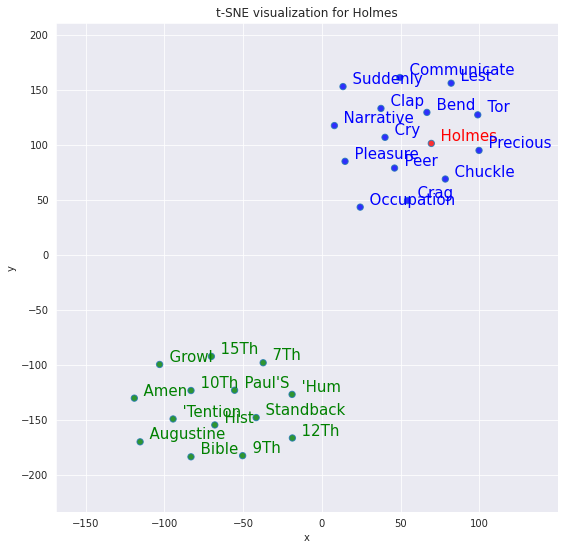

In [13]:
#-----------------------Parameters------------------------
word_ = 'holmes'
top_ = 14
embedding_size_ = 50
n_components_ = 20

#--------------Get similar and disimilar words------------
similar_words_ = get_top_n_similar_words(w2v_model, word_, top_)
disimilar_words_ = get_top_n_disimilar_words(w2v_model, word_, top_)

#---------------------------Get data from tSNE------------------------------
data, labels, colors = tsne_generation(w2v_model, word_, n_components_, similar_words_, disimilar_words_, embedding_size_)
plot_tsne(data, word_, labels, colors)